      Δrho, $   H_fit, mm     b_fit  σ_H, mm    a_fit      σ_a       R²
-2.000000e-01 1110.982995 -0.278379 5.306118 0.002018 0.000012 0.999818
-1.800000e-01 1110.982994 -0.258379 5.306118 0.002018 0.000012 0.999818
-1.600000e-01 1110.982995 -0.238379 5.306118 0.002018 0.000012 0.999818
-1.400000e-01 1110.982995 -0.218379 5.306118 0.002018 0.000012 0.999818
-1.200000e-01 1110.982995 -0.198379 5.306118 0.002018 0.000012 0.999818
-1.000000e-01 1110.982995 -0.178379 5.306118 0.002018 0.000012 0.999818
-8.000000e-02 1110.982995 -0.158379 5.306118 0.002018 0.000012 0.999818
-6.000000e-02 1110.982995 -0.138379 5.306118 0.002018 0.000012 0.999818
-4.000000e-02 1110.982995 -0.118379 5.306118 0.002018 0.000012 0.999818
-2.000000e-02 1110.982995 -0.098379 5.306118 0.002018 0.000012 0.999818
-1.110223e-16 1110.982995 -0.078379 5.306118 0.002018 0.000012 0.999818
 2.000000e-02 1110.982995 -0.058379 5.306118 0.002018 0.000012 0.999818
 4.000000e-02 1110.982995 -0.038379 5.306118 0.002018 0.000012 0

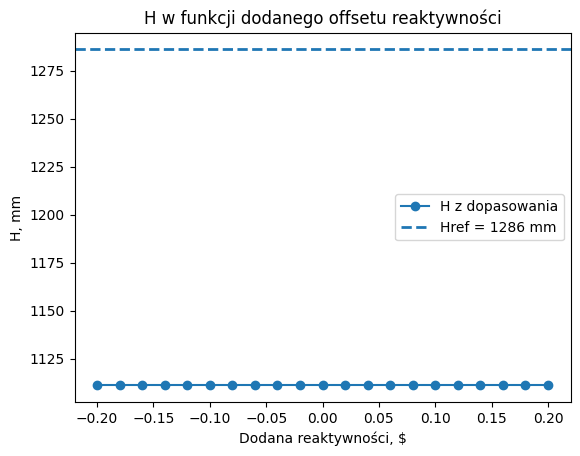

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

rho_dollar_delta = np.array([
    0.05194, 0.11857, 0.13843, 0.11836, 0.13575, 0.13604,
    0.12446, 0.11849, 0.12445, 0.12986, 0.12945
])

Polozenie_preta = np.array([
    219.0, 307.3, 388.9, 450.0, 517.6, 584.0,
    646.0, 712.0, 790.0, 883.0, 1099.3
])

rho_dollar = np.cumsum(rho_dollar_delta)

L = 1000.0  

def efektywnosc(z, H, L):
    z = np.asarray(z, dtype=float)

    idx = np.zeros_like(z, dtype=int)
    idx[(z >  -H/2)      & (z <  -H/2 + L)] = 1
    idx[(z >= -H/2 + L)  & (z <   H/2)]     = 2
    idx[(z >=  H/2)      & (z <   H/2 + L)] = 3

    wzory = [
        np.zeros_like(z),  
        (H/np.pi) * (np.sin(np.pi * z / H) + 1.0),                          
        (H/np.pi) * (np.sin(np.pi * z / H) - np.sin(np.pi * (z - L) / H)),  
        (H/np.pi) * (1.0 - np.sin(np.pi * (z - L) / H))                     
    ]
    return np.choose(idx, wzory)
#Funkcja dopasowania
def model_curvefit(X_mm, a, H):
    z = np.asarray(X_mm, dtype=float) - H/2 # przesuwam środek do prawdziwego środka
    return a * efektywnosc(z, H, L)  

X = Polozenie_preta
Y0 = rho_dollar

przesuniecie = np.arange(-0.2, 0.201, 0.02) 
rows = []


p0 = (0.002, 4000.0)                  
bounds = ([-np.inf, 10.0], [np.inf, 20000.0])
  #

for deltaRho in przesuniecie:
    Y = Y0 + deltaRho

    try:
        popt, pcov = curve_fit(model_curvefit, X, Y, p0=p0, bounds=bounds)
        a_fit, H_fit = popt
        sigma_a, sigma_H = np.sqrt(np.diag(pcov))

        Y_fit = model_curvefit(X, a_fit, H_fit)
        res = Y - Y_fit

        SSE = float(np.sum(res**2))
        SST = float(np.sum((Y - np.mean(Y))**2))
        R2 = 1.0 - SSE/SST if SST > 0 else np.nan


        rows.append({
            "Δrho, $": deltaRho,
            "H_fit, mm": H_fit,
            "σ_H, mm": sigma_H,
            "a_fit": a_fit,
            "σ_a": sigma_a,
            "R²": R2,

        })

    except Exception as e:
        rows.append({
            "Δrho, $": deltaRho,
            "H_fit, mm": np.nan,
            "σ_H, mm": np.nan,
            "a_fit": np.nan,
            "σ_a": np.nan,
            "R²": np.nan,

        })
#Wykreslenie wynikow
df = pd.DataFrame(rows)
print(df.to_string(index=False))

H_ref = 1286.0
df2 = df.dropna(subset=["H_fit, mm"]).sort_values("Δrho, $").reset_index(drop=True)

d = df2["Δrho, $"].to_numpy()
H = df2["H_fit, mm"].to_numpy()
sgn = np.sign(H - H_ref)

idx = np.where(sgn[:-1] * sgn[1:] < 0)[0]  
d_cross = None
if idx.size:
    i = idx[0]
    d_cross = d[i] + (H_ref - H[i]) * (d[i+1] - d[i]) / (H[i+1] - H[i])

plt.figure()
plt.plot(df["Δrho, $"], df["H_fit, mm"], marker="o", label="H z dopasowania")
plt.axhline(H_ref, linestyle="--", linewidth=2, label="Href = 1286 mm")

if d_cross is not None:
    plt.axvline(d_cross, linestyle=":", linewidth=2, label=f"Δρ dla H=1286: {d_cross:.3f} $")
    plt.scatter([d_cross], [H_ref], s=80)

plt.xlabel("Dodana reaktywności, $")
plt.ylabel("H, mm")
plt.title("H w funkcji dodanego offsetu reaktywności")
plt.legend()
plt.show()



In [5]:
# Gładka krzywa do wykresu
x_plot = np.linspace(X.min(), X.max(), 1000)
y_plot = model_curvefit(x_plot, a_fit, H_fit)


plt.figure()
plt.scatter(X, Y, label=r"Dane ($\rho$)")
plt.plot(x_plot, y_plot, label=r"Model dopasowany")
plt.xlabel(r"Położenie pręta, mm")
plt.ylabel(r"$\rho$, \$")
plt.title(r"Dopasowanie modelu efektywności pręta")
plt.legend()

plt.show()
print(a_fit, H_fit)

TypeError: model_curvefit() missing 1 required positional argument: 'b'